In [16]:
import os
import numpy as np
import tensorflow as tf
from keras.models import Sequential
import pathlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from keras.preprocessing.image import ImageDataGenerator
from keras.metrics import TruePositives, FalsePositives, TrueNegatives, FalseNegatives, BinaryAccuracy, Precision, Recall, AUC
from sklearn.preprocessing import MinMaxScaler

sns.set_context("talk")

# MLFPM symposium
### Student workshop - Part 1

Something about explainability and medical imaging bla bla

In [ ]:
!git clone https://github.com/mlfpm/MLFPM_symposium_workshop

In [42]:
repo_path = "MLFPM_symposium_workshop/Part 1 - Chest Xray classification and explainability/"

### Download data from Kaggle

In [3]:
!pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import opendatasets as op
op.download("https://www.kaggle.com/tawsifurrahman/covid19-radiography-database")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: lucasmiranda42
Your Kaggle Key: ··········


100%|██████████| 778M/778M [00:03<00:00, 245MB/s]


### Preprocess images

In [5]:
dataset_folder = os.path.join("covid19-radiography-database/COVID-19_Radiography_Dataset")

In [6]:
files_not_important = ["COVID.metadata.xlsx", 
                       "Lung_Opacity.metadata.xlsx",
                       "Normal.metadata.xlsx",
                       "README.md.txt",
                       "Viral Pneumonia.metadata.xlsx"]
for i in files_not_important:
    os.remove(os.path.join(dataset_folder, i))

In [7]:
import shutil
files_not_important = [
                       "COVID/masks",
                       "Lung_Opacity",
                       "Normal",
                       "Viral Pneumonia/masks"]
for i in files_not_important:
    shutil.rmtree(os.path.join(dataset_folder, i), ignore_errors=True)

In [8]:
datasetObject = pathlib.Path(os.path.join(dataset_folder))
images = list(datasetObject.glob("*/*/*.*"))

In [9]:
image_data_generator = ImageDataGenerator(
    rescale = 1/255, vertical_flip= False, horizontal_flip=True, zoom_range=0.1, zca_whitening=False,
    samplewise_center=True, samplewise_std_normalization=True, validation_split= 0.1,
    rotation_range=0.2)
training_dataset = image_data_generator.flow_from_directory(
    dataset_folder, target_size = (224, 224), color_mode ='rgb',subset='training', batch_size=8, shuffle=True
)
validation_dataset = image_data_generator.flow_from_directory(
    dataset_folder,  target_size=(224, 224), color_mode = 'rgb', subset='validation', batch_size = 8, shuffle = True
)

Found 4466 images belonging to 2 classes.
Found 495 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


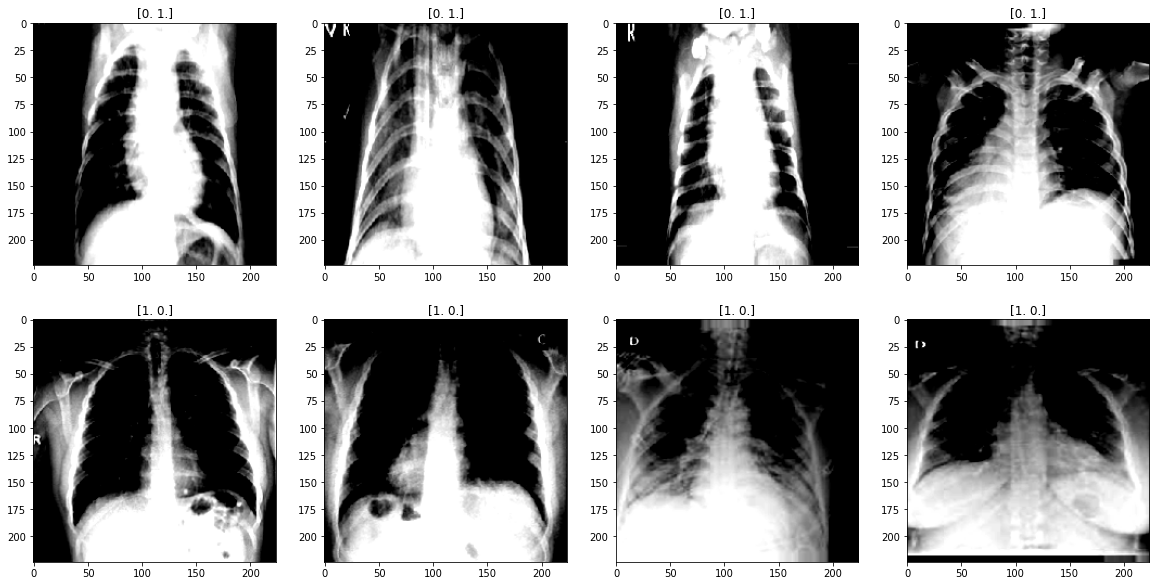

In [10]:
single_batch = training_dataset.next()
images = single_batch[0]
label = single_batch[1]
plt.figure(figsize = (20, 10))
for i in range(8):
    plt.subplot(2, 4, (i + 1))
    plt.imshow(np.clip(images[i], 0, 1))
    plt.title(label[i])
plt.show()

In [11]:
print('COVID cases:', (training_dataset.labels == 0).sum())
print('Viral pneumonia cases:', (training_dataset.labels == 1).sum())

COVID cases: 3255
Viral pneumonia cases: 1211


## Classification models

### PCA + LR baseline

In [12]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [13]:
n_train_batches = 200
n_val_batches = 50
X_train = []
y_train = []

X_val = []
y_val = []

pca_training_dataset = image_data_generator.flow_from_directory(
    dataset_folder, target_size = (224, 224), color_mode ='grayscale',subset='training', batch_size=8, shuffle=True
)
pca_validation_dataset = image_data_generator.flow_from_directory(
    dataset_folder, target_size = (224, 224), color_mode ='grayscale',subset='validation', batch_size=8, shuffle=True
)


for _ in range(n_train_batches):
    images, labels = pca_training_dataset.next()
    X_train.extend(images.reshape(8,-1))
    y_train.extend(labels)
    
for _ in range(n_val_batches):  
    val_images, val_labels = pca_validation_dataset.next()
    X_val.extend(val_images.reshape(8,-1))
    y_val.extend(val_labels)
    
X_train = np.vstack(X_train)
X_train -= np.mean(X_train, axis=0)
y_train = np.vstack(y_train)
X_val = np.vstack(X_val)
X_val -= np.mean(X_val, axis=0)
y_val = np.vstack(y_val)

Found 4466 images belonging to 2 classes.
Found 495 images belonging to 2 classes.


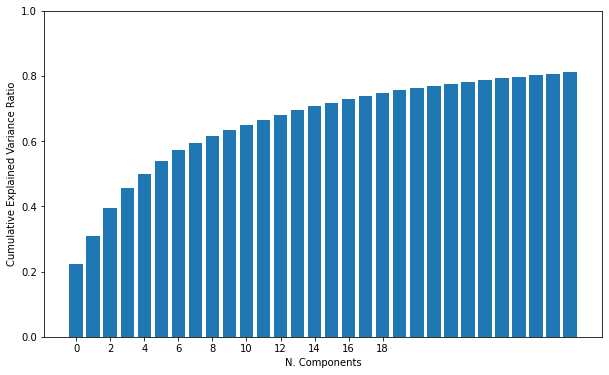

In [15]:
pca = PCA(n_components=100)
pca.fit(X_train)

fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(range(30), np.cumsum(pca.explained_variance_ratio_[:30]))
ax.set_ylim(0,1)
ax.set_ylabel("Cumulative Explained Variance Ratio")
ax.set_xlabel("N. Components")
ax.set_xticks(list(range(0,20,2)))
plt.show()


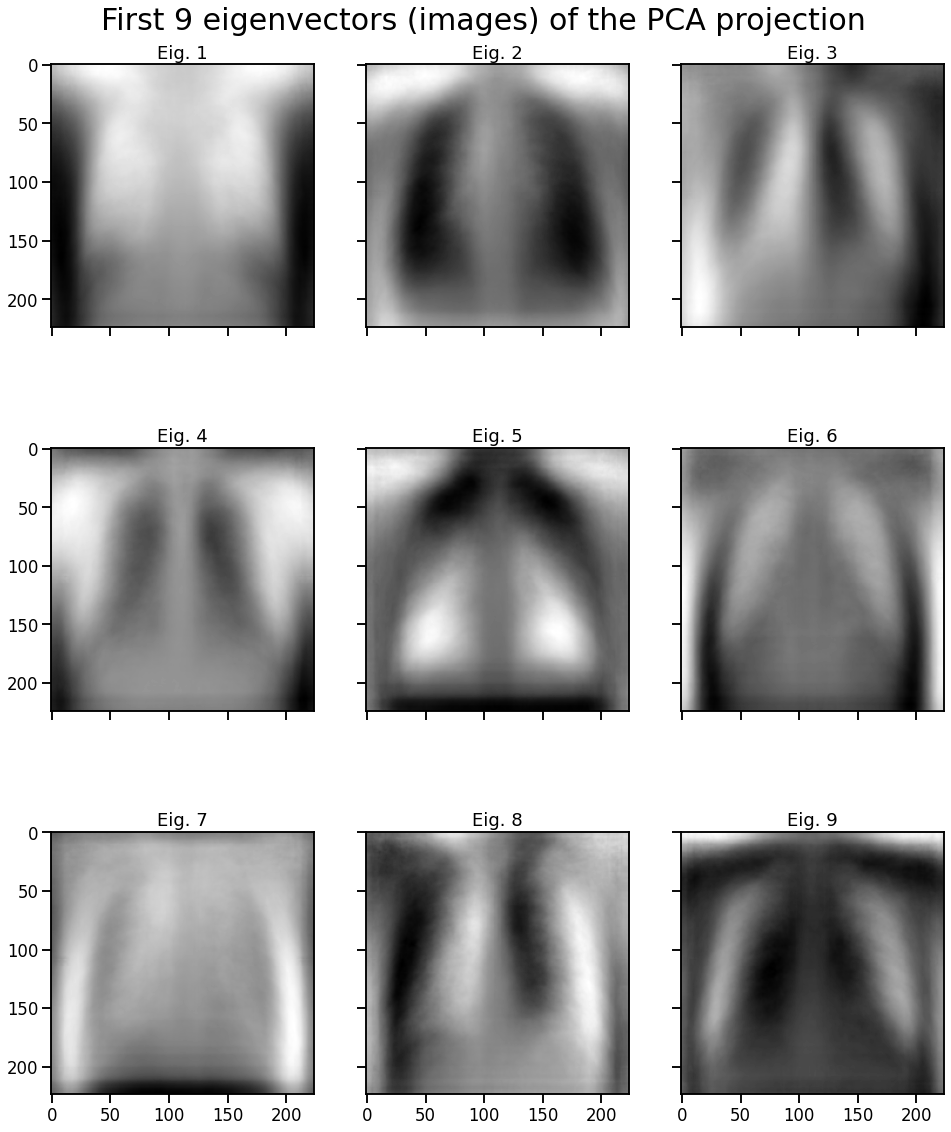

In [20]:
n_components = 32
eigenimages = pca.components_[:n_components]

# Show the first 9 eigenvectors
fig, axes = plt.subplots(3,3,sharex=True,sharey=True,figsize=(16,20))
for i in range(9):
    axes[i//3][i%3].imshow(eigenimages[i].reshape(224,224), cmap="gray")
    axes[i//3][i%3].set_title("Eig. {}".format(i+1))
    
fig.suptitle("First 9 eigenvectors (images) of the PCA projection", y=0.9, fontsize=30)
plt.show()

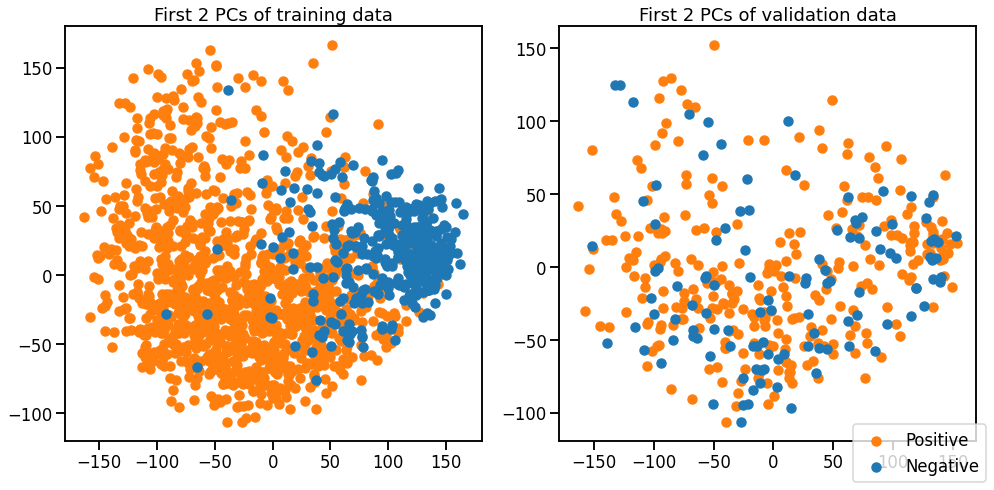

In [110]:
pca_embeddings_train = pca.transform(X_train)
pca_embeddings_val = pca.transform(X_val)
fig, axs = plt.subplots(1, 2, figsize=(14,7))

ix = np.where(y_train[:,0]==1)
neg_ix = np.where(y_train[:,0]==0)
axs[0].scatter(pca_embeddings_train[ix, 0], pca_embeddings_train[ix,1], s=80, color="#ff7f0e", label="Positive")
axs[0].scatter(pca_embeddings_train[neg_ix, 0], pca_embeddings_train[neg_ix,1], s=80, color="#1f77b4", label="Negative")
axs[0].set_title("First 2 PCs of training data")

ix = np.where(y_val[:,0]==1)
neg_ix = np.where(y_val[:,0]==0)
axs[1].scatter(pca_embeddings_train[ix, 0], pca_embeddings_train[ix,1], s=80, c="#ff7f0e")
axs[1].scatter(pca_embeddings_train[neg_ix, 0], pca_embeddings_train[neg_ix,1], s=80, color="#1f77b4")
axs[1].set_title("First 2 PCs of validation data")
fig.legend(loc="lower right")

plt.tight_layout()
plt.show()


In [24]:
sprint("Training Logistic Regression model")
lr = LogisticRegression(max_iter=1000)
lr.fit(pca_embeddings_train, y_train[:,0])

predictions = lr.predict(pca_embeddings_val)

print("Validation Accuracy: {:.2%}".format(accuracy_score(y_val[:,0], predictions)))


Training Logistic Regression model
Validation Accuracy: 94.00%


### Build and train a CNN classification model

We'll use a CNN, give some details bla bla

In [72]:
from keras.applications import densenet
from keras.initializers import GlorotNormal
d = densenet.DenseNet121(weights=None, include_top = False, input_shape = (224, 224, 3))

In [73]:
print(d.output_shape)
m = tf.keras.layers.Dropout(0.7)(d.output)
m = tf.keras.layers.GlobalAveragePooling2D()(m)                         
m = tf.keras.layers.Dropout(0.7)(m)
m = tf.keras.layers.Dense(2, kernel_initializer=GlorotNormal(),
                          activation = 'softmax', kernel_regularizer= tf.keras.regularizers.L2(0.0001),
                          bias_regularizer= tf.keras.regularizers.L2(0.0001))(m)
m = tf.keras.models.Model(inputs = d.input, outputs = m)

m.load_weights(os.path.join(repo_path, "CheXNet_Keras_0.3.0_raw_weights.h5"), by_name=True, skip_mismatch=True)

for layer in m.layers[:200]:
    layer.trainable = False
for layer in m.layers[200:]:
    layer.trainable = True

(None, 7, 7, 1024)


In [74]:
m.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), 
    loss = 'categorical_crossentropy', 
    metrics =  [
        TruePositives(name='tp'),
        FalsePositives(name='fp'),
        TrueNegatives(name='tn'),
        FalseNegatives(name='fn'), 
        'accuracy',
        Precision(name='precision'),
        Recall(name='recall')
      ]
    )

In [75]:
ReduceLROnPlateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.1, 
    mode = 'min',
    patience= 2
)

In [89]:
history = m.fit(
    training_dataset,
    validation_data = validation_dataset,
    batch_size = 8,
    epochs = 25, # Set to ~25 to reach good performance. Takes around 30 min on a GPU environment
    callbacks = [ReduceLROnPlateau, tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, mode = 'min', restore_best_weights=True)]
)

Epoch 1/25
559/559 [==============================] - 73s 131ms/step - loss: 0.1130 - tp: 4281.0000 - fp: 185.0000 - tn: 4281.0000 - fn: 185.0000 - accuracy: 0.9586 - precision: 0.9586 - recall: 0.9586 - val_loss: 0.0203 - val_tp: 491.0000 - val_fp: 4.0000 - val_tn: 491.0000 - val_fn: 4.0000 - val_accuracy: 0.9919 - val_precision: 0.9919 - val_recall: 0.9919 - lr: 1.0000e-04
Epoch 2/25
559/559 [==============================] - 72s 129ms/step - loss: 0.0242 - tp: 4444.0000 - fp: 22.0000 - tn: 4444.0000 - fn: 22.0000 - accuracy: 0.9951 - precision: 0.9951 - recall: 0.9951 - val_loss: 0.0158 - val_tp: 493.0000 - val_fp: 2.0000 - val_tn: 493.0000 - val_fn: 2.0000 - val_accuracy: 0.9960 - val_precision: 0.9960 - val_recall: 0.9960 - lr: 1.0000e-04
Epoch 3/25
559/559 [==============================] - 73s 130ms/step - loss: 0.0184 - tp: 4447.0000 - fp: 19.0000 - tn: 4447.0000 - fn: 19.0000 - accuracy: 0.9957 - precision: 0.9957 - recall: 0.9957 - val_loss: 0.0131 - val_tp: 492.0000 - val_fp

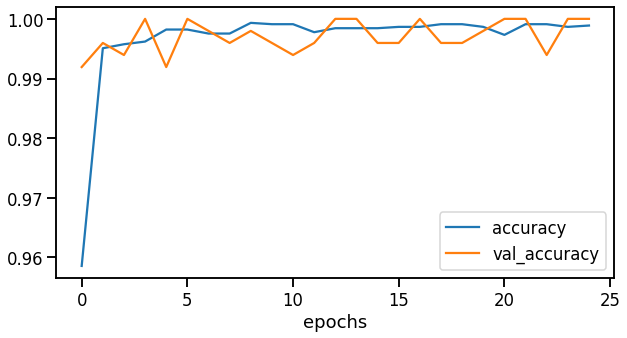

In [90]:
plt.figure(figsize = (10, 5))
plt.plot(history.history['accuracy'], label="accuracy")
plt.plot(history.history['val_accuracy'], label="val_accuracy")

plt.xlabel("epochs")

plt.legend()

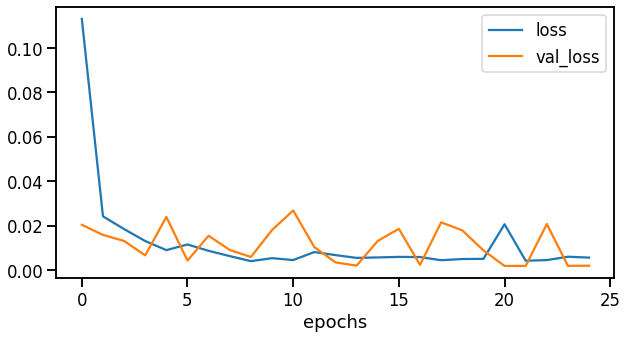

In [91]:
plt.figure(figsize = (10, 5))
plt.plot(history.history['loss'], label = "loss")
plt.plot(history.history['val_loss'], label = "val_loss")

plt.xlabel("epochs")

plt.legend()

In [98]:
# Load fine tuned weights
m.load_weights(os.path.join(repo_path, "CheXNet_Keras_0.3.0_fine_tuned_weights.h5"), by_name=True, skip_mismatch=True)

In [99]:
m.evaluate(validation_dataset, batch_size = 8)

62/62 [==============================] - 7s 112ms/step - loss: 0.0070 - tp: 494.0000 - fp: 1.0000 - tn: 494.0000 - fn: 1.0000 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980


[0.006959569174796343,
 494.0,
 1.0,
 494.0,
 1.0,
 0.9979798197746277,
 0.9979798197746277,
 0.9979798197746277]

### Performance comparison

### Model interpretation

##### 1. Manual error analysis

In [100]:
# TBD (meeting with a doctor on Monday, to make it a bit more interesting)

##### 2. Saliency maps

In [101]:
def get_saliency_map(model, image, class_idx):

    with tf.GradientTape() as tape:
        tape.watch(image)
        predictions = model(image)
        
        loss = predictions[:, class_idx]
    
    # Get the gradients of the loss w.r.t to the input image.
    gradient = tape.gradient(loss, image)
    
    # take maximum across channels
    gradient = tf.reduce_max(gradient, axis=-1)
    
    # convert to numpy
    gradient = gradient.numpy()
    
    # normaliz between 0 and 1
    min_val, max_val = np.min(gradient), np.max(gradient)
    smap = (gradient - min_val) / (max_val - min_val + tf.keras.backend.epsilon())
    
    return np.squeeze(smap)

In [102]:
test_image = validation_dataset.next()
test_image, test_label = test_image[0][0], int(test_image[1][0][1])

saliency = get_saliency_map(m, tf.expand_dims(test_image, axis=0), test_label)

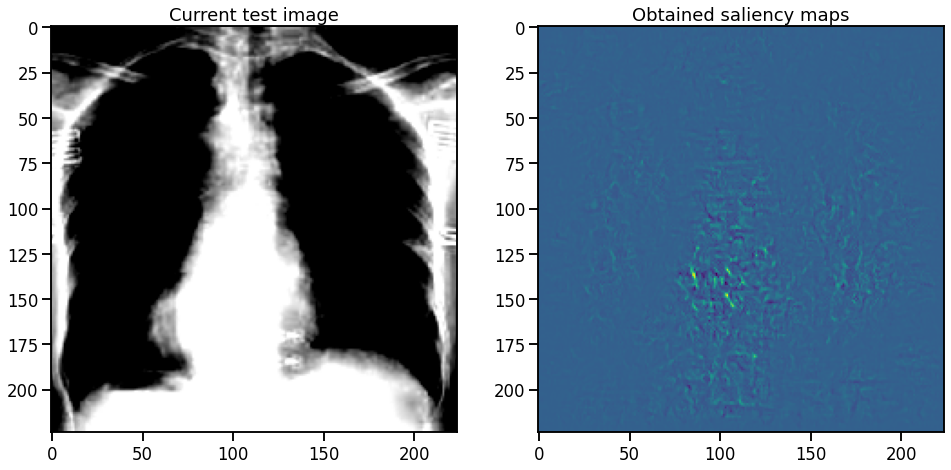

In [103]:
# Visualize image and raw heatmaps

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
sns.set_context("talk")

ax1.set_title("Current test image")
ax1.imshow(np.clip(test_image, 0, 1))

ax2.set_title("Obtained saliency maps")
ax2.imshow(saliency)

plt.show()

##### 3. Grad CAM

In [104]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):

    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [105]:
def gradcam_overlay(img, heatmap, alpha=0.4):

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

    return superimposed_img

In [106]:
test_image = validation_dataset.next()[0][0]

gradcam_outputs = make_gradcam_heatmap(
    tf.expand_dims(test_image, axis=0), 
    m, 
    "conv5_block16_2_conv", 
    pred_index=None
    )

gradcam_superimposed = gradcam_overlay(test_image, gradcam_outputs, alpha=0.01)

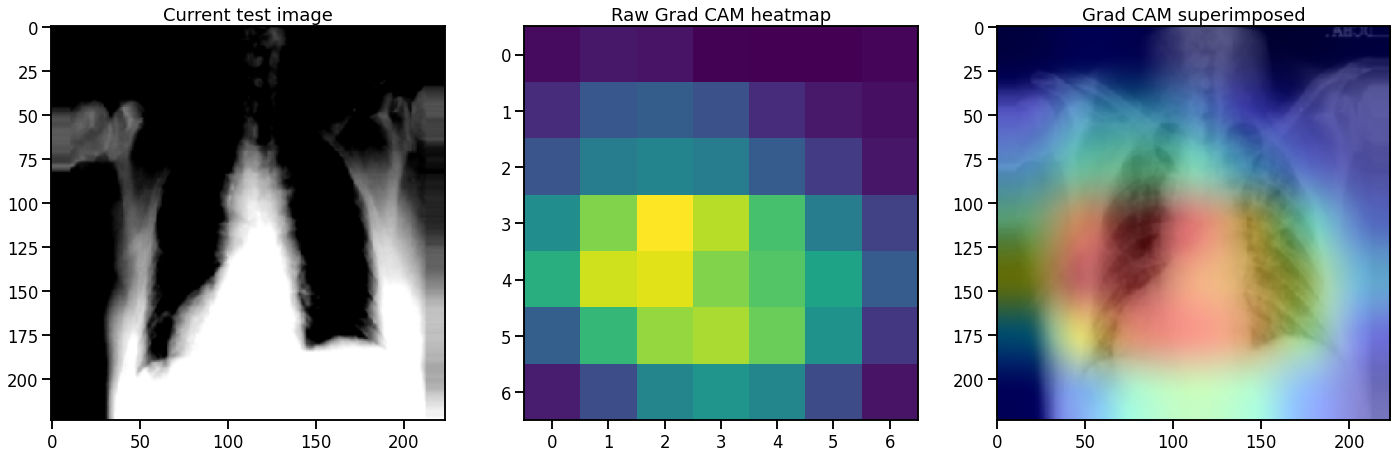

In [107]:
# Visualize image and raw heatmaps

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 16))
sns.set_context("talk")

ax1.set_title("Current test image")
ax1.imshow(np.clip(test_image, 0, 1))

ax2.set_title("Raw Grad CAM heatmap")
ax2.imshow(gradcam_outputs)

ax3.set_title("Grad CAM superimposed")
ax3.imshow(gradcam_superimposed)

plt.show()